In [2]:
from fptools import fp, stochastic, bayes
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from scipy.stats import norm, cauchy

# The ambiguity advantage

Implementing the unrestricted race model (URM; van Gompel et al., 2000) using the master equation.

1. Ambig: son of driver that had mustache
2. High pref.: driver of car that had mustache
3. Low pref.: car of driver that had mustache


In [113]:
# also try with init, high, 0.9, look for change in splitting probabilities
ambstates = """init, high, 0.9
init, low, 1.0
high, highcheck, 1.0
low, lowcheck, 1.0
highcheck, highabs, 1.0
lowcheck, lowabs, 1.0
"""
ambidx, _, _, ambW, ambT, ambA, _, _ = fp.make_sys(ambstates)
print(ambidx)

# Both identical
highstates = """init, high, 1.0
init, low, 0.9
high, highcheck, 1.0
low, lowcheck, 1.0
lowcheck, high, 1.0
highcheck, abs, 1.0
"""
highidx, _, _, highW, highT, highA, _, _ = fp.make_sys(highstates)

lowstates = """init, high, 0.9
init, low, 1.0
high, highcheck, 1.0
low, lowcheck, 1.0
highcheck, low, 1.0
lowcheck, abs, 1.0
"""
lowidx, _, _, lowW, lowT, lowA, _, _ = fp.make_sys(lowstates)
#print(ctlidx, ctlW)

{'init': 0, 'high': 1, 'low': 2, 'highcheck': 3, 'lowcheck': 4, 'highabs': 5, 'lowabs': 6}


[]

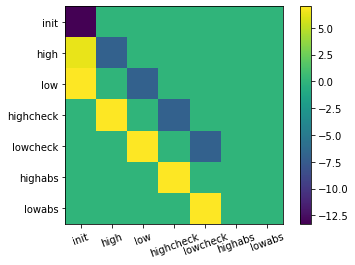

In [114]:
plt.imshow(ambW)
plt.xticks(ticks=range(7), labels=list(ambidx.keys()), rotation=20)
plt.yticks(ticks=range(7), labels=list(ambidx.keys()))
plt.colorbar()
plt.plot()

In [115]:
condnames = ['Ambiguous', 'High attachment', 'Low attachment']
conds = [[ambT, ambA, ambW], [highT, highA, highW], [lowT, lowA, lowW]]

for i in range(len(condnames)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[0] = 1.0
    print('{}:\n\tmean: {}, variance: {}'.format(condnames[i], *np.round(fp.meanvar(conds[i][0], p0), 6)))
    if i == 0:
        a, b = fp.cmfpt(conds[i][0], conds[i][1], p0)
        np.testing.assert_equal(a, b)  # Only gets thrown if there is a larger penalty for high
    print('\t', fp.cmfpt(conds[i][0], conds[i][1], p0), sep=' ')
    print('\t', fp.splittingprobabilities(conds[i][0], conds[i][1], p0), sep=' ')

Ambiguous:
	mean: 0.360902, variance: 0.04647
	 [0.36090226 0.36090226]
	 [0.47368421 0.52631579]
High attachment:
	mean: 0.578947, variance: 0.117267
	 [0.57894737]
	 [1.]
Low attachment:
	mean: 0.578947, variance: 0.117267
	 [0.57894737]
	 [1.]


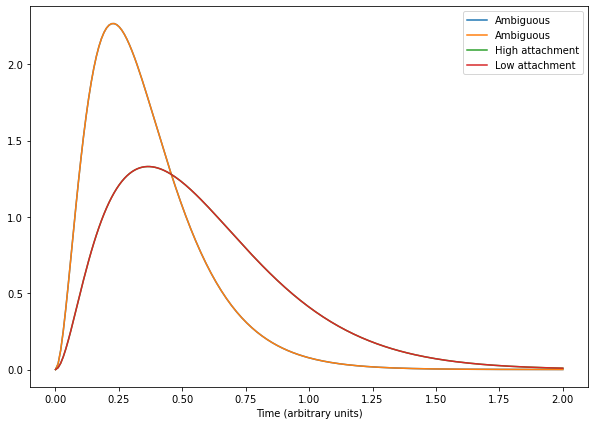

In [109]:
tvec = np.linspace(0.001, 2, 200)
plt.figure(figsize=(10, 7))
for i in range(len(conds)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[0] = 1.0
    #plt.plot(tvec, [fp.etd(t, conds[i][0], conds[i][1], p0) for t in tvec], label=condnames[i])
    plt.plot(tvec, [fp.cfptd(t, conds[i][0], conds[i][1], p0) for t in tvec], label=condnames[i])
plt.legend()
plt.xlabel('Time (arbitrary units)')
plt.show()

In [110]:
# Generating stochastic runs
stoch = []
for i in range(len(conds)):
     stoch.append(stochastic.rep_ssa(conds[i][-1], n=2000))

Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 6465.88it/s]


Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 7777.35it/s]


Running 2000 stochastic simulations until absorbtion


100%|██████████| 2000/2000 [00:00<00:00, 7534.00it/s]


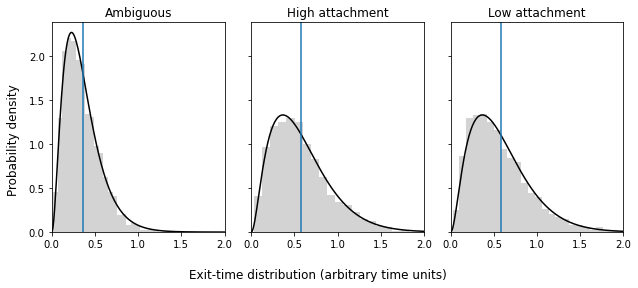

In [112]:
fig, axs = plt.subplots(1,3, sharex=True, sharey=True, squeeze=True, figsize=(9,4))
for i in range(len(conds)):
    p0 = np.zeros(conds[i][0].shape[0])
    p0[0] = 1.0
    axs.flat[i].plot(tvec, [fp.etd(t, conds[i][0], conds[i][1], p0) for t in tvec], color='k')
    axs.flat[i].hist(stoch[i]['fpt'], density=True, color='lightgrey', bins=25)
    axs.flat[i].set_title(condnames[i])
    axs.flat[i].set_xlim(0, max(tvec))
    axs.flat[i].axvline(fp.meanvar(conds[i][0], p0)[0])
fig.supxlabel('Exit-time distribution (arbitrary time units)')
fig.supylabel('Probability density')
fig.tight_layout()
fig.savefig('aaetd.pdf')
plt.show()